<a href="https://colab.research.google.com/github/srihasra-2002/Brain_tumor/blob/main/Brain_Tumor_Detection_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import cv2
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/brain_tumor_dataset'

ds = keras.utils.image_dataset_from_directory (
    directory = path,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (150, 150),
    shuffle = True,
)

Mounted at /content/drive
Found 253 files belonging to 2 classes.


In [3]:
DATASET_SIZE =len(ds)

train_ratio, test_ratio = 0.8, 0.2

train = ds.take(int(DATASET_SIZE * train_ratio))
test  = ds.skip(int(DATASET_SIZE * train_ratio))

val = ds.take (int(len(test) * 0.5))

print(len(train), len(test))

6 2


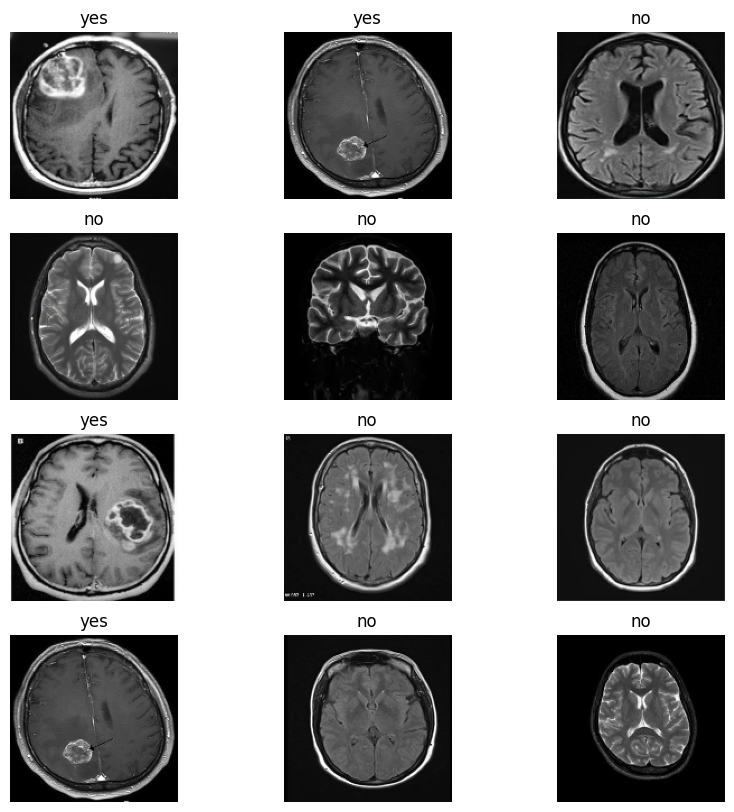

In [4]:
classes = ds.class_names

plt.figure (figsize = (10,10))

for image_batch, label_batch in ds.take(1):
    for i in range(12):
        axes = plt.subplot(4,3,i+1)
        plt.imshow (image_batch[i].numpy().astype('uint8'))
        plt.title (classes[label_batch[i]])
        plt.axis('off')

In [5]:
def augmentation (image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_crop(image, size= [32, 150, 150, 3])
    return image, label

new_train = train.map(augmentation)

def Scaler (image, label):
    image= tf.cast(image/255. , tf.float32)
    return image, label

new_train, new_test, new_val = new_train.map(Scaler), test.map(Scaler), val.map(Scaler)

In [6]:
model = Sequential([
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Dropout(0.25),
    Conv2D(32, kernel_size= (3,3), activation= 'relu', padding= 'same'),
    MaxPooling2D(pool_size= (2,2)),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
])

# Adding SVM Layer
model.add(
    Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation= 'linear')
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 32)        0

In [23]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))
    img = np.array(img)
    img = img / 255.0  # Normalize pixel values
    return img

In [9]:
model.compile (
    optimizer ='adam',
    loss ='hinge',
    metrics = ['accuracy']
)
early_stopping = EarlyStopping (
    monitor = 'loss',
    patience = 3,
    restore_best_weights =True,
)
history= model.fit (
    new_train,
    epochs =25,
    validation_data = new_val,
    batch_size= 32,
    verbose= 1,
    callbacks = [early_stopping]
)

Epoch 1/25
6/6 [==============================] - 16s 2s/step - loss: 0.9114 - accuracy: 0.4948 - val_loss: 0.9198 - val_accuracy: 0.3750
Epoch 2/25
6/6 [==============================] - 22s 3s/step - loss: 0.8130 - accuracy: 0.6302 - val_loss: 0.9070 - val_accuracy: 0.2812
Epoch 3/25
6/6 [==============================] - 15s 2s/step - loss: 0.8481 - accuracy: 0.6042 - val_loss: 0.9606 - val_accuracy: 0.4062
Epoch 4/25
6/6 [==============================] - 13s 2s/step - loss: 0.7864 - accuracy: 0.6458 - val_loss: 0.9084 - val_accuracy: 0.2812
Epoch 5/25
6/6 [==============================] - 14s 2s/step - loss: 0.8604 - accuracy: 0.5885 - val_loss: 1.0073 - val_accuracy: 0.5000
Epoch 6/25
6/6 [==============================] - 7s 1s/step - loss: 0.8157 - accuracy: 0.6354 - val_loss: 1.0039 - val_accuracy: 0.5312
Epoch 7/25
6/6 [==============================] - 8s 1s/step - loss: 0.8474 - accuracy: 0.6042 - val_loss: 0.9486 - val_accuracy: 0.3438


In [10]:
loss, accuracy = model.evaluate(new_test)

print(loss, accuracy)

2/2 [==============================] - 1s 202ms/step - loss: 0.9591 - accuracy: 0.3934
0.9590874910354614 0.39344263076782227


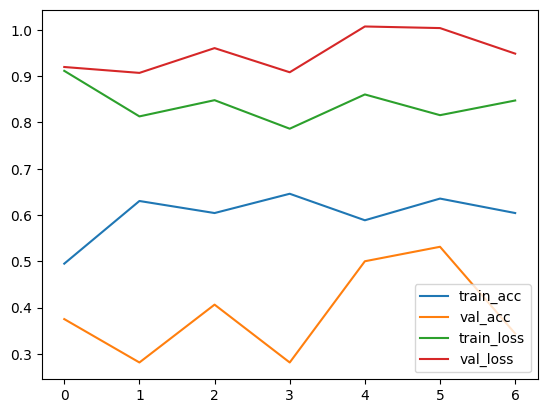

In [11]:
plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'])

In [12]:
true_labels, pred_labels = [], []

for images, labels in new_test:
    true_labels.extend(labels.numpy())
    pred = model.predict(images)
    for p in pred:
        res = 0 if p < 0 else 1
        pred_labels.append(res)

true, predicted = np.array(true_labels), np.array(pred_labels)

1/1 [==============================] - 0s 314ms/step


<Axes: >

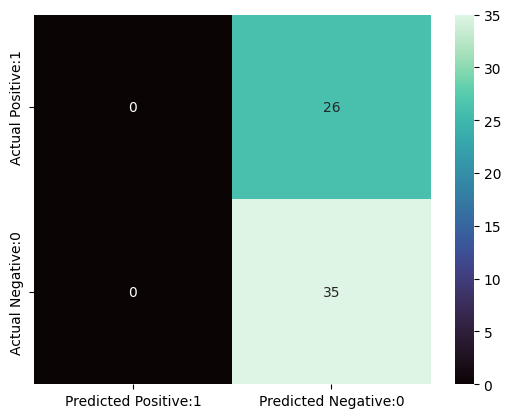

In [13]:
cm = confusion_matrix(true, predicted)
cm_matrix = pd.DataFrame(data=cm, columns=['Predicted Positive:1', 'Predicted Negative:0'], index=['Actual Positive:1', 'Actual Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt = 'd', cmap='mako')

In [14]:
report = classification_report(true, predicted)

print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.57      1.00      0.73        35

    accuracy                           0.57        61
   macro avg       0.29      0.50      0.36        61
weighted avg       0.33      0.57      0.42        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


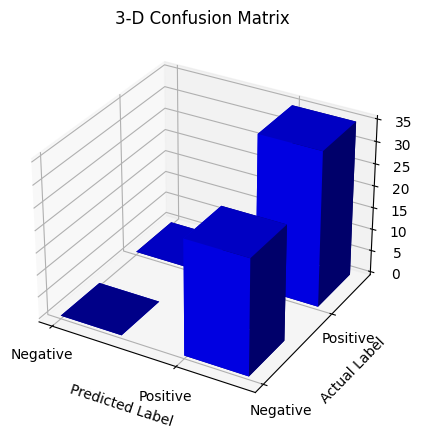

In [15]:
confusion_matrix = np.array(cm)

x_coords, y_coords = np.meshgrid(np.arange(confusion_matrix.shape[0]), np.arange(confusion_matrix.shape[1]))
x_coords, y_coords = x_coords.flatten(), y_coords.flatten()
z_coords = np.zeros_like(x_coords)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(x_coords, y_coords, z_coords, dx=0.5, dy=0.5, dz=confusion_matrix.flatten(), color='b')

ax.set_xlabel('Predicted Label')
ax.set_ylabel('Actual Label')
ax.set_zlabel('Count')
ax.set_title('3-D Confusion Matrix')

ax.set_xticks(np.arange(confusion_matrix.shape[0]))
ax.set_yticks(np.arange(confusion_matrix.shape[1]))
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])

plt.show()

In [24]:
uploaded_image_path = 'bt.jpeg'
uploaded_image = preprocess_image(uploaded_image_path)

In [25]:
prediction = model.predict(np.expand_dims(uploaded_image, axis=0))

# Interpret the prediction
if prediction[0][0] < 0:
    print("Predicted: No Brain Tumor")
else:
    print("Predicted: Brain Tumor Detected")

1/1 [==============================] - 0s 64ms/step
Predicted: Brain Tumor Detected
